## Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive/Neural_Legal_Judgment_Prediction"

# !git clone https://github.com/helmy-elrais/RoBERT_Recurrence_over_BERT

Mounted at /content/drive
/content/drive/MyDrive/Neural_Legal_Judgment_Prediction


## Install necessary libraries

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.1 MB/s eta 0:00:00


##Imports

In [3]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
import transformers
from transformers import RobertaTokenizer, BertTokenizer, BertModel, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, recall_score, precision_score, mean_absolute_error
from utils import Utils
from data_wrangling import ECHRDataset
from Bert_Classification import Bert_Classification_Model
from RoBERT import RoBERT_Model
from ToBERT import ToBERT_Model
from Bert_Hierarchical import BERT_Hierarchical_Model, BERT_Hierarchical_Model_Reg
import warnings
warnings.filterwarnings("ignore")

## Check GPU

In [4]:
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Data Exploration

In [ ]:
# Load the dataset into a pandas dataframe.
df = pd.read_csv("/content/drive/MyDrive/Graduation project/CSVs/data.csv", dtype="unicode")

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

train_raw = df[df.Text.notnull()]
print('Number of training sentences with case facts not null: {:,}\n'.format(train_raw.shape[0]))

# Display 5 random rows from the data.
train_raw.sample(5)

Number of training sentences: 11,478

Number of training sentences with case facts not null: 11,478



,ID,LAN,Respondent,Branch,Date,Name,Importance,Conclusion,Judges,Text,VIOA,VIOP,VIOB,NON_VIOA,NON_VIOP,NON_VIOB
8329,001-159071,ENG,CZE,CHAMBER,2015,CASE OF REGNER v. THE CZECH REPUBLIC,3,No violation of Article 6 - Right to a fair tr...,Aleš Pejchal;André Potocki;Angelika Nußberger;...,['5. The applicant was born in 1962 and lives ...,[],[],[],['6'],['6-1'],[]
9712,001-179410,ENG,RUS,COMMITTEE,2017,CASE OF INDERKINY v. RUSSIA,4,Violation of Article 6 - Right to a fair trial...,Alena Poláčková;Helen Keller;Pere Pastor Vilanova,['4. The applicants are a family. They were bo...,"['13', '6', 'P1']","['6-1', 'P1-1']",['P1-1-1'],[],[],[]
5589,001-85583,ENG,HRV,CHAMBER,2008,CASE OF PERIC v. CROATIA,3,Violation of Art. 6-1;Remainder inadmissible;N...,Christos Rozakis;Dean Spielmann;George Nicolao...,['4. The applicant was born in 1919 and lives ...,['6'],['6-1'],[],[],[],[]
5731,001-86678,ENG,POL,CHAMBER,2008,CASE OF PANUSZ v. POLAND,4,No violation of Article 5 - Right to liberty a...,David Thór Björgvinsson;Giovanni Bonello;Lech ...,['4. The applicant was born in 1967 and lives ...,['8'],[],[],['5'],[],[]
9851,001-181178,ENG,MKD,CHAMBER,2018,"CASE OF SELAMI AND OTHERS v. ""THE FORMER YUGOS...",3,Preliminary objection joined to merits and dis...,Aleš Pejchal;Krzysztof Wojtyczek;Linos-Alexand...,"['5. The applicants alleged, before the domest...","['3', '5']",['5-5'],[],[],[],[]


<Axes: title={'center': 'number of occurrences by number of words'}, ylabel='Frequency'>

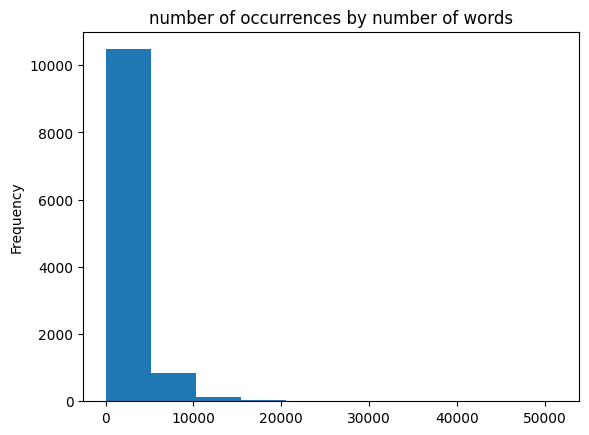

In [ ]:
train_raw.Text.apply(lambda x: len(x.split())).plot(kind='hist', title="number of occurrences by number of words")

In [ ]:
#creates a new column that contains the number of words in each case facts
train_raw['len_txt'] =train_raw.Text.apply(lambda x: len(x.split()))

# Create a DataFrame of the summary statistics of the len_txt column
len_txt_stats = pd.DataFrame(train_raw['len_txt'].describe())

# Print the DataFrame
len_txt_stats

,len_txt
count,11478.000000
mean,2225.380815
std,2559.068761
min,12.000000
25%,715.250000
50%,1524.000000
75%,2804.250000
max,51334.000000


In [ ]:
# Report the number of sentences.
print('Number of training sentences before filtering: {:,}\n'.format(train_raw.shape[0]))
temp = train_raw[(train_raw.len_txt >= 200) & (train_raw.len_txt < 15000)]
print('Number of training sentences after filtering: {:,}\n'.format(temp.shape[0]))

Number of training sentences before filtering: 11,478

Number of training sentences after filtering: 10,736



In [ ]:
# Display 5 random rows from the data.
train_raw.sample(5)

,ID,LAN,Respondent,Branch,Date,Name,Importance,Conclusion,Judges,Text,VIOA,VIOP,VIOB,NON_VIOA,NON_VIOP,NON_VIOB,len_txt
1097,001-111419,ENG,GEO,CHAMBER,2012,CASE OF DADIANI AND MACHABELI v. GEORGIA,4,Violation of Article 6 - Right to a fair trial...,Alvina Gyulumyan;Corneliu Bîrsan;Egbert Myjer;...,"['5. The applicants, Mrs Elene Dadiani and Mr ...",['6'],['6-1'],[],[],[],[],800
4107,001-70368,ENG,POL,CHAMBER,2005,CASE OF KANKOWSKI v. POLAND,4,Violation of Art. 5-3;Pecuniary damage - claim...,Nicolas Bratza,['4. The applicant was born in 1974 and lives ...,['5'],['5-3'],[],[],[],[],1972
9227,001-172550,ENG,RUS,COMMITTEE,2017,CASE OF NOSENKO AND OTHERS v. RUSSIA,4,Violation of Article 5 - Right to liberty and ...,Branko Lubarda;Dmitry Dedov;Luis López Guerra,['3. The list of applicants and the relevant d...,['5'],['5-3'],[],[],[],[],31
7376,001-144673,ENG,RUS,CHAMBER,2014,CASE OF PRIMOV AND OTHERS v. RUSSIA,3,Remainder inadmissible;Violation of Article 11...,Dmitry Dedov;Erik Møse;Isabelle Berro-Lefèvre;...,['5. On 10 April 2006 a group of seven people ...,['11'],['11-1'],[],['11'],['11-1'],[],5495
9413,001-174970,ENG,RUS,COMMITTEE,2017,CASE OF KUDRYAVTSEV AND OTHERS v. RUSSIA,4,Violation of Article 3 - Prohibition of tortur...,Dmitry Dedov;Luis López Guerra,['3. The list of applicants and the relevant d...,"['13', '3']",[],[],[],[],[],42


## Declaring variables

In [5]:
CHUNK_LEN = 200
OVERLAP_LEN = 50
TRAIN_BATCH_SIZE = 8
EPOCH = 6
shuffle_dataset = True
random_seed = 42
b_utl = Utils(task_type = "binary violation")
c_utl = Utils(task_type = "case importance")
m_utl = Utils(task_type = "multi label")

## Loading tokenizer

In [6]:
print('Loading BERT tokenizer...')
bert_tokenizer = BertTokenizer.from_pretrained('nlpaueb/bert-base-uncased-echr', do_lower_case=True)

Loading BERT tokenizer...


## Fine-tuning on the 200 tokens chunks (First segmetation approach : all, task type : binary violation)


In [ ]:
task_type = "binary violation"
approach = "all"

train_dataset = ECHRDataset(
    tokenizer = bert_tokenizer,
    chunk_len = CHUNK_LEN,
    file_location = "/content/drive/MyDrive/Graduation project/CSVs/final train data.csv",
    overlap_len=OVERLAP_LEN,
    task_type = task_type,
    approach = approach)

valid_dataset=ECHRDataset(
    tokenizer=bert_tokenizer,
    chunk_len = CHUNK_LEN,
    file_location = "/content/drive/MyDrive/Graduation project/CSVs/test data.csv",
    overlap_len = OVERLAP_LEN,
    task_type = task_type,
    approach = approach)

# Creating data indices for training and validation splits:
train_dataset_size = len(train_dataset)
valid_dataset_size = len(valid_dataset)
train_indices = list(range(train_dataset_size))
val_indices = list(range(valid_dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


train_data_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler = train_sampler,
    collate_fn = b_utl.collate_samples)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = TRAIN_BATCH_SIZE,
    sampler = valid_sampler,
    collate_fn = b_utl.collate_samples)

device = "cuda"
lr = 3e-5
num_training_steps = int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCH)

# create an instance of the model
model = Bert_Classification_Model(task_type).to(device)

# load the state dictionary of the saved model into the new model instance
# model = torch.load("/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/bv-model-all/model_epoch(len_txt<2805)3.pt")

optimizer = AdamW(model.parameters(), lr = lr)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses=[]
batches_losses=[]
val_acc=[]
train_f1 = []
val_f1 = []


for epoch in range(EPOCH):

    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp, batches_f1_tmp = b_utl.bert_tobert_training_loop(train_data_loader, model, optimizer, device, calculate_f1 = True)
    epoch_loss = np.mean(batches_losses_tmp)
    epoch_f1 = np.mean(batches_f1_tmp)
    print(f"\n==> train : avg_loss : {epoch_loss:.2f}")
    batches_f1_tmp = np.array(batches_f1_tmp)
    train_f1.append(batches_f1_tmp.mean())
    output, target, val_losses_tmp = b_utl.bert_tobert_evaluation_loop(valid_data_loader, model, device)
    print(f"\n==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}\n")
    tmp_evaluate = b_utl.evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_f1.append(tmp_evaluate['F1-Score'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    torch.save(model, f"/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/bv-model-all/model_epoch{epoch+1}.pt")
    print("\t§§ model has been saved §§")

Some weights of the model checkpoint at nlpaueb/bert-base-uncased-echr were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



=============== EPOCH 1 / 3 ===============

___ batch index = 0 / 1054 (0.00%), loss = 0.7085 ___
___ batch index = 250 / 1054 (23.72%), loss = 0.5773 ___
___ batch index = 500 / 1054 (47.44%), loss = 0.4520 ___
___ batch index = 750 / 1054 (71.16%), loss = 0.4706 ___
___ batch index = 1000 / 1054 (94.88%), loss = 0.4195 ___

==> train : avg_loss : 0.50

==> evaluation : avg_loss = 0.54

=====>	{'accuracy': 76.43, 'F1-Score': 71.95, 'Precision': 75.84, 'Recall': 70.66}
	§§ model has been saved §§

=============== EPOCH 2 / 3 ===============

___ batch index = 0 / 1054 (0.00%), loss = 0.3783 ___
___ batch index = 250 / 1054 (23.72%), loss = 0.2971 ___
___ batch index = 500 / 1054 (47.44%), loss = 0.3496 ___
___ batch index = 750 / 1054 (71.16%), loss = 0.4090 ___
___ batch index = 1000 / 1054 (94.88%), loss = 0.2902 ___

==> train : avg_loss : 0.36

==> evaluation : avg_loss = 0.51

=====>	{'accuracy': 69.72, 'F1-Score': 75.82, 'Precision': 76.83, 'Recall': 75.15}
	§§ model has been s

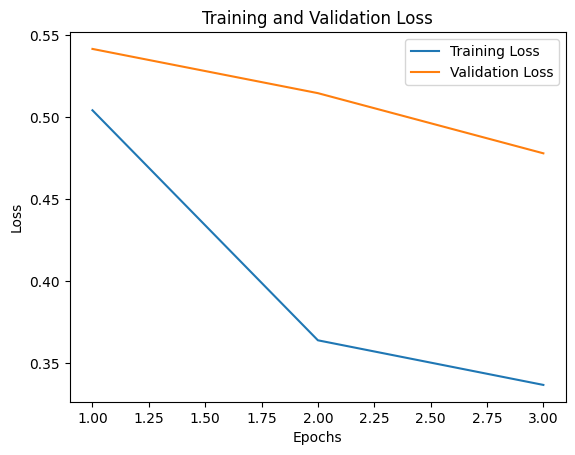

In [ ]:
# Get mean losses for each epoch
train_loss = [np.mean(x) for x in batches_losses]
val_loss = [np.mean(x) for x in val_losses]
# Plot losses
epochs = range(1, EPOCH+1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# Save the figure
plt.savefig('/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/figures/bva Train and Val Loss.png')
# show the figure
plt.show()

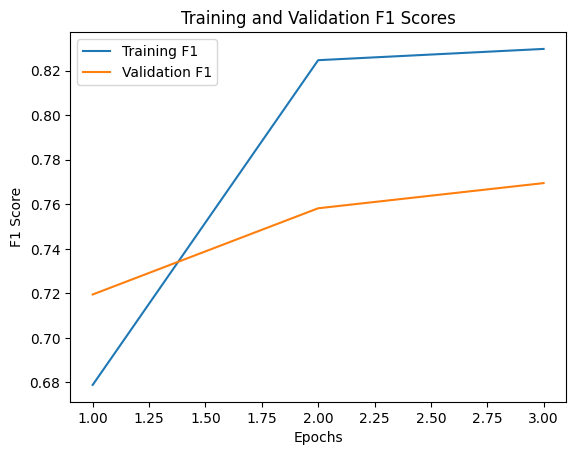

In [ ]:
# Plot F1 scores
epochs = range(1, EPOCH+1)
norm_val_f1 = [x/100 for x in val_f1]
plt.plot(epochs, train_f1, label='Training F1')
plt.plot(epochs, norm_val_f1, label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Scores')
plt.legend()
# Save the figure
plt.savefig('/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/figures/bva Train and Val F1.png')
# show the figure
plt.show()

## Second segmentation approach : head (task type : binary violation)


In [ ]:
task_type = "binary violation"
approach = "head"

train_dataset = ECHRDataset(
    tokenizer = bert_tokenizer,
    chunk_len = CHUNK_LEN,
    file_location = "/content/drive/MyDrive/Graduation project/CSVs/final train data.csv",
    overlap_len = OVERLAP_LEN,
    task_type = task_type,
    approach = approach)

valid_dataset = ECHRDataset(
    tokenizer = bert_tokenizer,
    chunk_len = CHUNK_LEN,
    file_location = "/content/drive/MyDrive/Graduation project/CSVs/test data.csv",
    overlap_len = OVERLAP_LEN,
    task_type = task_type,
    approach = approach)

# Creating data indices for training and validation splits:
train_dataset_size = len(train_dataset)
valid_dataset_size = len(valid_dataset)
train_indices = list(range(train_dataset_size))
val_indices = list(range(valid_dataset_size))

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader = DataLoader(
    train_dataset,
    batch_size = TRAIN_BATCH_SIZE,
    sampler = train_sampler,
    collate_fn = b_utl.collate_samples)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = TRAIN_BATCH_SIZE,
    sampler = valid_sampler,
    collate_fn = b_utl.collate_samples)


device = "cuda"
lr = 3e-5
num_training_steps = int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCH)

model = Bert_Classification_Model(task_type).to(device)
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses = []
batches_losses = []
val_acc = []
train_f1 = []
val_f1 = []

for epoch in range(EPOCH):

    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp, batches_f1_tmp = b_utl.bert_tobert_training_loop(train_data_loader, model, optimizer, device, calculate_f1 = True)
    epoch_loss = np.mean(batches_losses_tmp)
    epoch_f1 = np.mean(batches_f1_tmp)
    print(f"\n==> train : avg_loss : {epoch_loss:.2f}")
    batches_f1_tmp = np.array(batches_f1_tmp)
    train_f1.append(batches_f1_tmp.mean())
    output, target, val_losses_tmp = b_utl.bert_tobert_evaluation_loop(valid_data_loader, model, device)
    print(f"\n==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}\n")
    tmp_evaluate = b_utl.evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_f1.append(tmp_evaluate['F1-Score'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    torch.save(model, f"/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/bv-model-head/model_epoch{epoch+1}.pt")
    print(f"\t§§ Truncation {approach} only model has been saved §§")

Some weights of the model checkpoint at nlpaueb/bert-base-uncased-echr were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



=============== EPOCH 1 / 3 ===============

___ batch index = 0 / 1060 (0.00%), loss = 0.6644 ___
___ batch index = 250 / 1060 (23.58%), loss = 0.5582 ___
___ batch index = 500 / 1060 (47.17%), loss = 0.3772 ___
___ batch index = 750 / 1060 (70.75%), loss = 0.3179 ___
___ batch index = 1000 / 1060 (94.34%), loss = 0.3815 ___

==> train : avg_loss : 0.46

==> evaluation : avg_loss = 0.44

=====>	{'accuracy': 72.72, 'F1-Score': 75.55, 'Precision': 77.71, 'Recall': 74.44}
	§§ Truncation head only model has been saved §§

=============== EPOCH 2 / 3 ===============

___ batch index = 0 / 1060 (0.00%), loss = 0.3291 ___
___ batch index = 250 / 1060 (23.58%), loss = 0.2806 ___
___ batch index = 500 / 1060 (47.17%), loss = 0.3382 ___
___ batch index = 750 / 1060 (70.75%), loss = 0.2850 ___
___ batch index = 1000 / 1060 (94.34%), loss = 0.3112 ___

==> train : avg_loss : 0.33

==> evaluation : avg_loss = 0.42

=====>	{'accuracy': 72.21, 'F1-Score': 76.32, 'Precision': 78.3, 'Recall': 75.25}


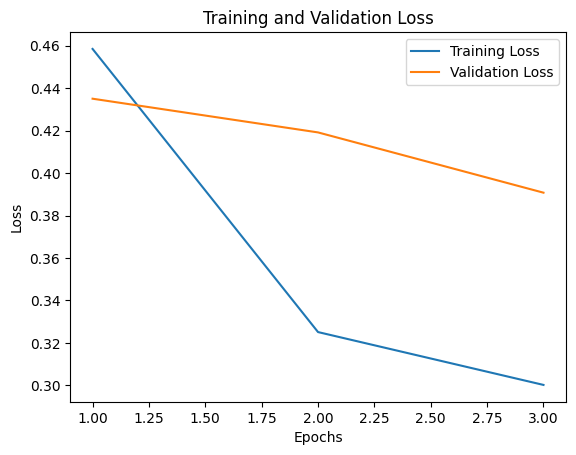

In [ ]:
# Get mean losses for each epoch
train_loss = [np.mean(x) for x in batches_losses]
val_loss = [np.mean(x) for x in val_losses]
# Plot losses
epochs = range(1, EPOCH+1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# Save the figure
plt.savefig('/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/figures/bvh Train and Val Loss.png')
# show the figure
plt.show()

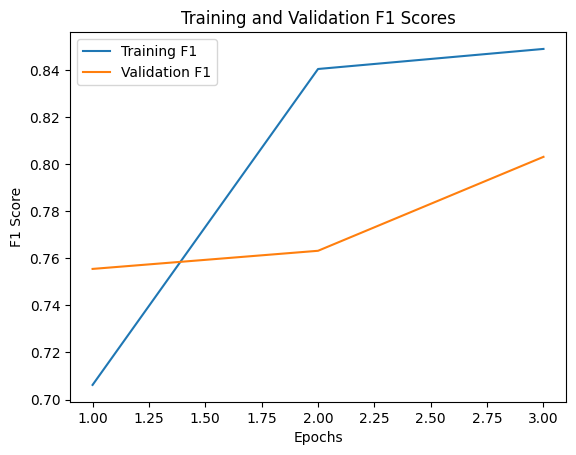

In [ ]:
# Plot F1 scores
epochs = range(1, EPOCH+1)
norm_val_f1 = [x/100 for x in val_f1]
plt.plot(epochs, train_f1, label='Training F1')
plt.plot(epochs, norm_val_f1, label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Scores')
plt.legend()
# Save the figure
plt.savefig('/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/figures/bvh Train and Val F1.png')
# show the figure
plt.show()

## Third segmetation approach : tail (task type : binary violation)


In [ ]:
task_type = "binary violation"
approach = "tail"

train_dataset = ECHRDataset(
    tokenizer = bert_tokenizer,
    chunk_len = CHUNK_LEN,
    file_location = "/content/drive/MyDrive/Graduation project/CSVs/final train data.csv",
    overlap_len = OVERLAP_LEN,
    task_type = task_type,
    approach=approach)

valid_dataset = ECHRDataset(
    tokenizer = bert_tokenizer,
    chunk_len = CHUNK_LEN,
    file_location = "/content/drive/MyDrive/Graduation project/CSVs/test data.csv",
    overlap_len = OVERLAP_LEN,
    task_type = task_type,
    approach = approach)

# Creating data indices for training and validation splits:
train_dataset_size = len(train_dataset)
valid_dataset_size = len(valid_dataset)
train_indices = list(range(train_dataset_size))
val_indices = list(range(valid_dataset_size))

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader = DataLoader(
    train_dataset,
    batch_size = TRAIN_BATCH_SIZE,
    sampler = train_sampler,
    collate_fn = b_utl.collate_samples)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = TRAIN_BATCH_SIZE,
    sampler = valid_sampler,
    collate_fn = b_utl.collate_samples)


device = "cuda"
lr = 3e-5
num_training_steps = int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCH)

model = Bert_Classification_Model(task_type).to(device)
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses = []
batches_losses = []
val_acc = []
train_f1 = []
val_f1 = []

for epoch in range(EPOCH):

    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp, batches_f1_tmp = b_utl.bert_tobert_training_loop(train_data_loader, model, optimizer, device, calculate_f1 = True)
    epoch_loss = np.mean(batches_losses_tmp)
    epoch_f1 = np.mean(batches_f1_tmp)
    print(f"\n==> train : avg_loss : {epoch_loss:.2f}")
    batches_f1_tmp = np.array(batches_f1_tmp)
    train_f1.append(batches_f1_tmp.mean())
    output, target, val_losses_tmp = b_utl.bert_tobert_evaluation_loop(valid_data_loader, model, device)
    print(f"\n==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}\n")
    tmp_evaluate = b_utl.evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_f1.append(tmp_evaluate['F1-Score'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    torch.save(model, f"/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/bv-model-tail/model_epoch{epoch+1}.pt")
    print(f"\t§§ Truncation {approach} only model has been saved §§")

Some weights of the model checkpoint at nlpaueb/bert-base-uncased-echr were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



=============== EPOCH 1 / 3 ===============

___ batch index = 0 / 1060 (0.00%), loss = 0.6944 ___
___ batch index = 250 / 1060 (23.58%), loss = 0.6151 ___
___ batch index = 500 / 1060 (47.17%), loss = 0.5364 ___
___ batch index = 750 / 1060 (70.75%), loss = 0.4646 ___
___ batch index = 1000 / 1060 (94.34%), loss = 0.3789 ___

==> train : avg_loss : 0.53

==> evaluation : avg_loss = 0.51

=====>	{'accuracy': 78.19, 'F1-Score': 75.01, 'Precision': 80.67, 'Recall': 73.26}
	§§ Truncation tail only model has been saved §§

=============== EPOCH 2 / 3 ===============

___ batch index = 0 / 1060 (0.00%), loss = 0.5698 ___
___ batch index = 250 / 1060 (23.58%), loss = 0.5418 ___
___ batch index = 500 / 1060 (47.17%), loss = 0.3547 ___
___ batch index = 750 / 1060 (70.75%), loss = 0.3624 ___
___ batch index = 1000 / 1060 (94.34%), loss = 0.3004 ___

==> train : avg_loss : 0.40

==> evaluation : avg_loss = 0.45

=====>	{'accuracy': 75.22, 'F1-Score': 78.7, 'Precision': 82.59, 'Recall': 77.01}


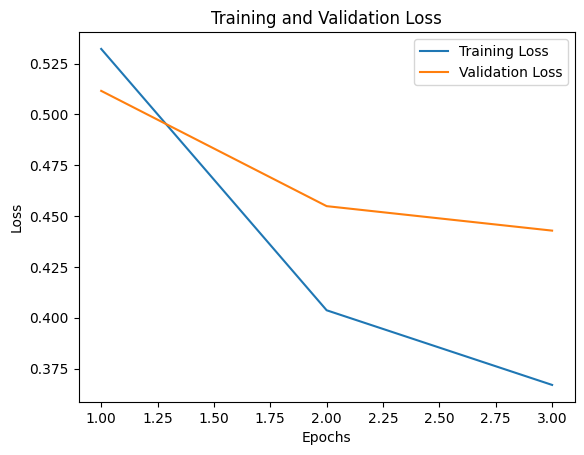

In [ ]:
# Get mean losses for each epoch
train_loss = [np.mean(x) for x in batches_losses]
val_loss = [np.mean(x) for x in val_losses]
# Plot losses
epochs = range(1, EPOCH+1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# Save the figure
plt.savefig('/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/figures/bvt Train and Val Loss.png')
# show the figure
plt.show()

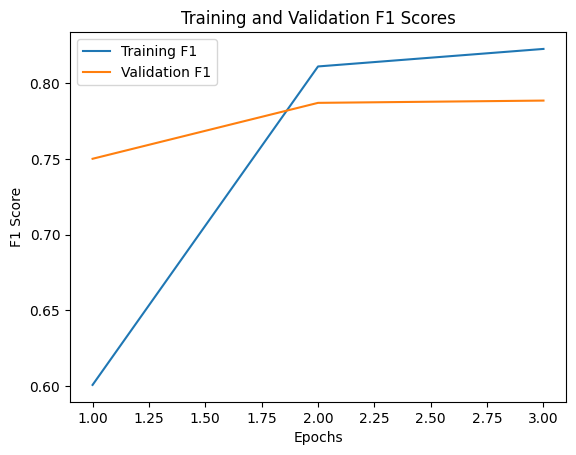

In [ ]:
# Plot F1 scores
epochs = range(1, EPOCH+1)
norm_val_f1 = [x/100 for x in val_f1]
plt.plot(epochs, train_f1, label='Training F1')
plt.plot(epochs, norm_val_f1, label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Scores')
plt.legend()
# Save the figure
plt.savefig('/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/figures/bvt Train and Val F1.png')
# show the figure
plt.show()

## Hierarchical Method (Mean Pooling) (task type : binary violation)


In [ ]:
task_type = "binary violation"
pooling_method = "mean"

train_dataset = ECHRDataset(
    tokenizer = bert_tokenizer,
    chunk_len = CHUNK_LEN,
    file_location = "/content/drive/MyDrive/Graduation project/CSVs/final train data.csv",
    overlap_len = OVERLAP_LEN,
    task_type = task_type,
    )

valid_dataset = ECHRDataset(
    tokenizer = bert_tokenizer,
    chunk_len = CHUNK_LEN,
    file_location = "/content/drive/MyDrive/Graduation project/CSVs/test data.csv",
    overlap_len = OVERLAP_LEN,
    task_type = task_type,
    )

train_dataset_size = len(train_dataset)
valid_dataset_size = len(valid_dataset)
train_indices = list(range(train_dataset_size))
val_indices = list(range(valid_dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(train_indices)

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader = DataLoader(
    train_dataset,
    batch_size = TRAIN_BATCH_SIZE,
    sampler = train_sampler,
    collate_fn = b_utl.collate_samples)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = TRAIN_BATCH_SIZE,
    sampler = valid_sampler,
    collate_fn = b_utl.collate_samples)


device = "cuda"
lr = 3e-5
num_training_steps = int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCH)

model_hierarchical = BERT_Hierarchical_Model(pooling_method = pooling_method, task_type = task_type).to(device)
optimizer = AdamW(model_hierarchical.parameters(), lr = lr)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses = []
batches_losses = []
val_acc = []
train_f1 = []
val_f1 = []

for epoch in range(EPOCH):

    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp, batches_f1_tmp = b_utl.hbert_lstm_training_loop(train_data_loader, model_hierarchical, optimizer, device, calculate_f1 = True)
    epoch_loss=np.mean(batches_losses_tmp)
    epoch_f1 = np.mean(batches_f1_tmp)
    print(f"\n==> train : avg_loss : {epoch_loss:.2f}")
    batches_f1_tmp = np.array(batches_f1_tmp)
    train_f1.append(batches_f1_tmp.mean())
    output, target, val_losses_tmp = b_utl.hbert_lstm_evaluation_loop(valid_data_loader, model_hierarchical, device)
    print(f"\n==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}\n")
    tmp_evaluate = b_utl.evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_f1.append(tmp_evaluate['F1-Score'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    torch.save(model_hierarchical, f"/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/bv-model-mean/model_epoch{epoch+1}.pt")
    print(f"\t§§ the Hierarchical {pooling_method} pooling model has been saved §§")

Some weights of the model checkpoint at nlpaueb/bert-base-uncased-echr were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



=============== EPOCH 1 / 3 ===============

___ batch index = 0 / 1054 (0.00%), loss = 0.6794 ___
___ batch index = 250 / 1054 (23.72%), loss = 0.3717 ___
___ batch index = 500 / 1054 (47.44%), loss = 0.2524 ___
___ batch index = 750 / 1054 (71.16%), loss = 0.2982 ___
___ batch index = 1000 / 1054 (94.88%), loss = 0.2774 ___

==> train : avg_loss : 0.33

==> evaluation : avg_loss = 0.33

=====>	{'accuracy': 78.86, 'F1-Score': 83.36, 'Precision': 91.37, 'Recall': 80.62}
	§§ the Hierarchical mean pooling model has been saved §§

=============== EPOCH 2 / 3 ===============

___ batch index = 0 / 1054 (0.00%), loss = 0.4860 ___
___ batch index = 250 / 1054 (23.72%), loss = 0.3188 ___
___ batch index = 500 / 1054 (47.44%), loss = 0.3697 ___
___ batch index = 750 / 1054 (71.16%), loss = 0.2808 ___
___ batch index = 1000 / 1054 (94.88%), loss = 0.1050 ___

==> train : avg_loss : 0.28

==> evaluation : avg_loss = 0.34

=====>	{'accuracy': 78.36, 'F1-Score': 83.41, 'Precision': 90.85, 'Recall

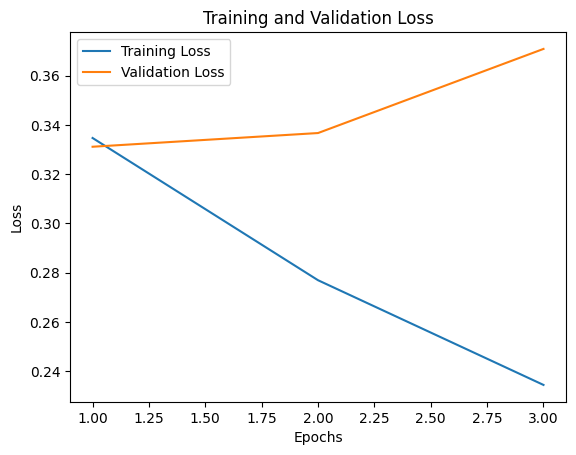

In [ ]:
# Get mean losses for each epoch
train_loss = [np.mean(x) for x in batches_losses]
val_loss = [np.mean(x) for x in val_losses]
# Plot losses
epochs = range(1, EPOCH+1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# Save the figure
plt.savefig('/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/figures/bvmean Train and Val Loss.png')
# show the figure
plt.show()

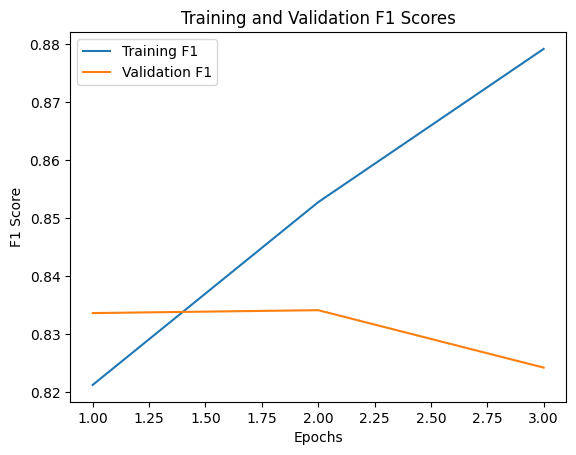

In [ ]:
# Plot F1 scores
epochs = range(1, EPOCH+1)
norm_val_f1 = [x/100 for x in val_f1]
plt.plot(epochs, train_f1, label='Training F1')
plt.plot(epochs, norm_val_f1, label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Scores')
plt.legend()
# Save the figure
plt.savefig('/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/figures/bvmean Train and Val F1.png')
# show the figure
plt.show()

## Hierarchical Method (Max Pooling) (task type : binary violation)


In [ ]:
task_type = "binary violation"
pooling_method = "max"

train_dataset = ECHRDataset(
    tokenizer = bert_tokenizer,
    chunk_len = CHUNK_LEN,
    file_location = "/content/drive/MyDrive/Graduation project/CSVs/final train data.csv",
    overlap_len = OVERLAP_LEN,
    task_type = task_type,
    )

valid_dataset=ECHRDataset(
    tokenizer = bert_tokenizer,
    chunk_len = CHUNK_LEN,
    file_location = "/content/drive/MyDrive/Graduation project/CSVs/test data.csv",
    overlap_len = OVERLAP_LEN,
    task_type = task_type,
    )

train_dataset_size = len(train_dataset)
valid_dataset_size = len(valid_dataset)
train_indices = list(range(train_dataset_size))
val_indices = list(range(valid_dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(train_indices)

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader = DataLoader(
    train_dataset,
    batch_size = TRAIN_BATCH_SIZE,
    sampler = train_sampler,
    collate_fn =  b_utl.collate_samples)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = TRAIN_BATCH_SIZE,
    sampler = valid_sampler,
    collate_fn =  b_utl.collate_samples)


device = "cuda"
lr = 3e-5
num_training_steps = int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCH)

model_hierarchical = BERT_Hierarchical_Model(pooling_method=pooling_method, task_type = task_type).to(device)
optimizer = AdamW(model_hierarchical.parameters(), lr = lr)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses = []
batches_losses = []
val_acc = []
train_f1 = []
val_f1 = []

for epoch in range(EPOCH):

    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp, batches_f1_tmp = b_utl.hbert_lstm_training_loop(train_data_loader, model_hierarchical, optimizer, device, calculate_f1 = True)
    epoch_loss = np.mean(batches_losses_tmp)
    epoch_f1 = np.mean(batches_f1_tmp)
    print(f"\n==> train : avg_loss : {epoch_loss:.2f}")
    batches_f1_tmp = np.array(batches_f1_tmp)
    train_f1.append(batches_f1_tmp.mean())
    output, target, val_losses_tmp = b_utl.hbert_lstm_evaluation_loop(valid_data_loader, model_hierarchical, device)
    print(f"\n==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}\n")
    tmp_evaluate = b_utl.evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_f1.append(tmp_evaluate['F1-Score'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    torch.save(model_hierarchical, f"/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/bv-model-max/model_epoch{epoch+1}.pt")
    print(f"\t§§ the Hierarchical {pooling_method} pooling model has been saved §§")

Some weights of the model checkpoint at nlpaueb/bert-base-uncased-echr were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



=============== EPOCH 1 / 3 ===============

___ batch index = 0 / 1054 (0.00%), loss = 0.6761 ___
___ batch index = 250 / 1054 (23.72%), loss = 0.3007 ___
___ batch index = 500 / 1054 (47.44%), loss = 0.3819 ___
___ batch index = 750 / 1054 (71.16%), loss = 0.2796 ___
___ batch index = 1000 / 1054 (94.88%), loss = 0.3112 ___

==> train : avg_loss : 0.33

==> evaluation : avg_loss = 0.35

=====>	{'accuracy': 78.12, 'F1-Score': 82.66, 'Precision': 89.71, 'Recall': 80.13}
	§§ the Hierarchical max pooling model has been saved §§

=============== EPOCH 2 / 3 ===============

___ batch index = 0 / 1054 (0.00%), loss = 0.3659 ___
___ batch index = 250 / 1054 (23.72%), loss = 0.2481 ___
___ batch index = 500 / 1054 (47.44%), loss = 0.2934 ___
___ batch index = 750 / 1054 (71.16%), loss = 0.2711 ___
___ batch index = 1000 / 1054 (94.88%), loss = 0.2048 ___

==> train : avg_loss : 0.28

==> evaluation : avg_loss = 0.36

=====>	{'accuracy': 78.16, 'F1-Score': 83.28, 'Precision': 90.48, 'Recall'

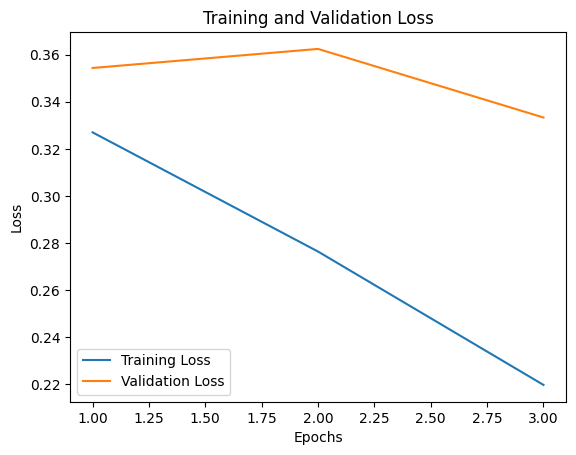

In [ ]:
# Get mean losses for each epoch
train_loss = [np.mean(x) for x in batches_losses]
val_loss = [np.mean(x) for x in val_losses]
# Plot losses
epochs = range(1, EPOCH+1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# Save the figure
plt.savefig('/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/figures/bvmax Train and Val Loss.png')
# show the figure
plt.show()

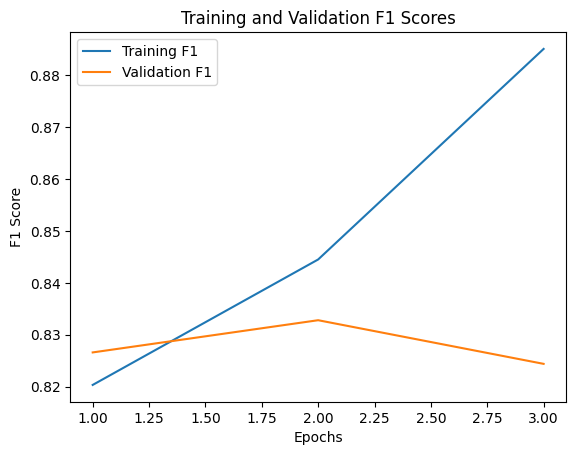

In [ ]:
# Plot F1 scores
epochs = range(1, EPOCH+1)
norm_val_f1 = [x/100 for x in val_f1]
plt.plot(epochs, train_f1, label='Training F1')
plt.plot(epochs, norm_val_f1, label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Scores')
plt.legend()
# Save the figure
plt.savefig('/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/figures/bvmax Train and Val F1.png')
# show the figure
plt.show()

## RoBERT RNN classifier on top of the Fine Tuned Bert Model (task type : binary violation)






In [ ]:
task_type = "binary violation"

train_dataset = ECHRDataset(
    tokenizer = bert_tokenizer,
    chunk_len = CHUNK_LEN,
    file_location = "/content/drive/MyDrive/Graduation project/CSVs/final train data.csv",
    overlap_len = OVERLAP_LEN,
    task_type = task_type,
    )

valid_dataset = ECHRDataset(
    tokenizer=bert_tokenizer,
    chunk_len = CHUNK_LEN,
    file_location = "/content/drive/MyDrive/Graduation project/CSVs/test data.csv",
    overlap_len = OVERLAP_LEN,
    task_type = task_type,
    )

# Creating data indices for training and validation splits:
train_dataset_size = len(train_dataset)
valid_dataset_size = len(valid_dataset)
train_indices = list(range(train_dataset_size))
val_indices = list(range(valid_dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader = DataLoader(
    train_dataset,
    batch_size = TRAIN_BATCH_SIZE,
    sampler = train_sampler,
    collate_fn = b_utl.collate_samples)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = TRAIN_BATCH_SIZE,
    sampler = valid_sampler,
    collate_fn = b_utl.collate_samples)

device = "cuda"
lr = 3e-5
num_training_steps = int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCH)

model = torch.load("/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/bv-model-all/model_epoch3.pt")

model_rnn = RoBERT_Model(bertFineTuned=list(model.children())[0], task_type= task_type).to(device)
optimizer = AdamW(model_rnn.parameters(), lr = lr)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses = []
batches_losses = []
val_acc = []
train_f1 = []
val_f1 = []

for epoch in range(EPOCH):

    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp, batches_f1_tmp = b_utl.hbert_lstm_training_loop(train_data_loader, model_rnn, optimizer, device, calculate_f1 = True)
    epoch_loss = np.mean(batches_losses_tmp)
    epoch_f1 = np.mean(batches_f1_tmp)
    print(f"\n==> train : avg_loss : {epoch_loss:.2f}")
    batches_f1_tmp = np.array(batches_f1_tmp)
    train_f1.append(batches_f1_tmp.mean())
    output, target, val_losses_tmp = b_utl.hbert_lstm_evaluation_loop(valid_data_loader, model_rnn, device)
    print(f"\n==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}\n")
    tmp_evaluate = b_utl.evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_f1.append(tmp_evaluate['F1-Score'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    torch.save(model_rnn, f"/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/bv-model-robert/model_epoch{epoch+1}.pt")
    print("\t§§ the RNN model has been saved §§")


=============== EPOCH 1 / 3 ===============

___ batch index = 0 / 1054 (0.00%), loss = 0.6946 ___
___ batch index = 250 / 1054 (23.72%), loss = 0.3991 ___
___ batch index = 500 / 1054 (47.44%), loss = 0.3978 ___
___ batch index = 750 / 1054 (71.16%), loss = 0.2497 ___
___ batch index = 1000 / 1054 (94.88%), loss = 0.3169 ___

==> train : avg_loss : 0.40

==> evaluation : avg_loss = 0.38

=====>	{'accuracy': 79.4, 'F1-Score': 82.67, 'Precision': 91.19, 'Recall': 79.91}
	§§ the RNN model has been saved §§

=============== EPOCH 2 / 3 ===============

___ batch index = 0 / 1054 (0.00%), loss = 0.3177 ___
___ batch index = 250 / 1054 (23.72%), loss = 0.3543 ___
___ batch index = 500 / 1054 (47.44%), loss = 0.3155 ___
___ batch index = 750 / 1054 (71.16%), loss = 0.3705 ___
___ batch index = 1000 / 1054 (94.88%), loss = 0.1686 ___

==> train : avg_loss : 0.31

==> evaluation : avg_loss = 0.36

=====>	{'accuracy': 79.33, 'F1-Score': 82.68, 'Precision': 91.12, 'Recall': 79.93}
	§§ the RNN m

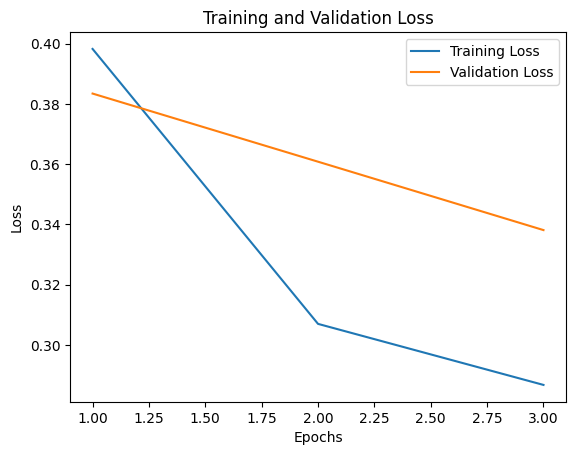

In [ ]:
# Get mean losses for each epoch
train_loss = [np.mean(x) for x in batches_losses]
val_loss = [np.mean(x) for x in val_losses]
# Plot losses
epochs = range(1, EPOCH+1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# Save the figure
plt.savefig('/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/figures/bvro Train and Val Loss.png')
# show the figure
plt.show()

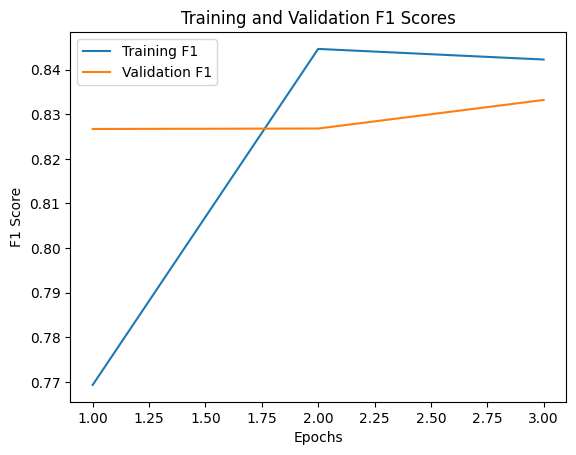

In [ ]:
# Plot F1 scores
epochs = range(1, EPOCH+1)
norm_val_f1 = [x/100 for x in val_f1]
plt.plot(epochs, train_f1, label='Training F1')
plt.plot(epochs, norm_val_f1, label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Scores')
plt.legend()
# Save the figure
plt.savefig('/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/figures/bvro Train and Val F1.png')
# show the figure
plt.show()

## ToBERT on top of the Fine Tuned Bert Model (task type : binary violation)


In [ ]:
task_type = "binary violation"

train_dataset = ECHRDataset(
    tokenizer = bert_tokenizer,
    chunk_len = CHUNK_LEN,
    file_location = "/content/drive/MyDrive/Graduation project/CSVs/final train data.csv",
    overlap_len=OVERLAP_LEN,
    task_type = task_type,
    )

valid_dataset=ECHRDataset(
    tokenizer=bert_tokenizer,
    chunk_len = CHUNK_LEN,
    file_location = "/content/drive/MyDrive/Graduation project/CSVs/test data.csv",
    overlap_len = OVERLAP_LEN,
    task_type = task_type,
    )

# Creating data indices for training and validation splits:
train_dataset_size = len(train_dataset)
valid_dataset_size = len(valid_dataset)
train_indices = list(range(train_dataset_size))
val_indices = list(range(valid_dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader = DataLoader(
    train_dataset,
    batch_size = TRAIN_BATCH_SIZE,
    sampler = train_sampler,
    collate_fn = b_utl.collate_samples)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = TRAIN_BATCH_SIZE,
    sampler = valid_sampler,
    collate_fn = b_utl.collate_samples)

device = "cuda"
lr = 3e-5
num_training_steps = int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCH)

model = torch.load("/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/bv-model-all/model_epoch3.pt")

model_tobert = ToBERT_Model(bertFineTuned = list(model.children())[0], task_type= task_type).to(device)
optimizer = AdamW(model_tobert.parameters(), lr = lr)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses = []
batches_losses = []
val_acc = []
train_f1 = []
val_f1 = []

for epoch in range(EPOCH):

    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp, batches_f1_tmp = b_utl.bert_tobert_training_loop(train_data_loader, model_tobert, optimizer, device, calculate_f1 = True)
    epoch_loss = np.mean(batches_losses_tmp)
    epoch_f1 = np.mean(batches_f1_tmp)
    print(f"\n==> train : avg_loss : {epoch_loss:.2f}")
    batches_f1_tmp = np.array(batches_f1_tmp)
    train_f1.append(batches_f1_tmp.mean())
    output, target, val_losses_tmp = b_utl.bert_tobert_evaluation_loop(valid_data_loader, model_tobert, device)
    print(f"\n==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}\n")
    tmp_evaluate = b_utl.evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_f1.append(tmp_evaluate['F1-Score'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    print("\t§§ the tobert model has been saved §§")
    torch.save(model_tobert, f"/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/bv-model-tobert/model_epoch{epoch+1}.pt")


=============== EPOCH 1 / 3 ===============

___ batch index = 0 / 1054 (0.00%), loss = 0.7279 ___
___ batch index = 250 / 1054 (23.72%), loss = 0.2289 ___
___ batch index = 500 / 1054 (47.44%), loss = 0.3429 ___
___ batch index = 750 / 1054 (71.16%), loss = 0.3718 ___
___ batch index = 1000 / 1054 (94.88%), loss = 0.1622 ___

==> train : avg_loss : 0.35

==> evaluation : avg_loss = 0.39

=====>	{'accuracy': 78.44, 'F1-Score': 80.71, 'Precision': 87.74, 'Recall': 78.33}
	§§ the tobert model has been saved §§

=============== EPOCH 2 / 3 ===============

___ batch index = 0 / 1054 (0.00%), loss = 0.3776 ___
___ batch index = 250 / 1054 (23.72%), loss = 0.2892 ___
___ batch index = 500 / 1054 (47.44%), loss = 0.2902 ___
___ batch index = 750 / 1054 (71.16%), loss = 0.3179 ___
___ batch index = 1000 / 1054 (94.88%), loss = 0.3610 ___

==> train : avg_loss : 0.30

==> evaluation : avg_loss = 0.41

=====>	{'accuracy': 78.81, 'F1-Score': 79.54, 'Precision': 86.74, 'Recall': 77.23}
	§§ the t

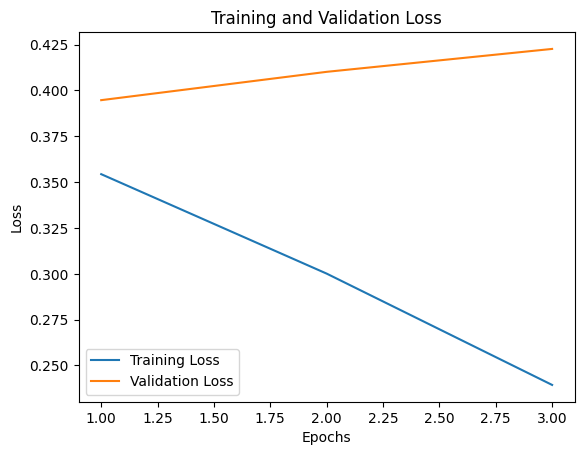

In [ ]:
# Get mean losses for each epoch
train_loss = [np.mean(x) for x in batches_losses]
val_loss = [np.mean(x) for x in val_losses]
# Plot losses
epochs = range(1, EPOCH+1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# Save the figure
plt.savefig('/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/figures/bvto Train and Val Loss.png')
# show the figure
plt.show()

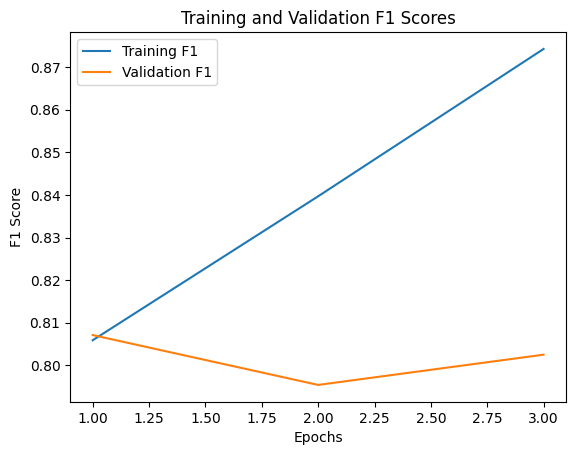

In [ ]:
# Plot F1 scores
epochs = range(1, EPOCH+1)
norm_val_f1 = [x/100 for x in val_f1]
plt.plot(epochs, train_f1, label='Training F1')
plt.plot(epochs, norm_val_f1, label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Scores')
plt.legend()
# Save the figure
plt.savefig('/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/figures/bvto Train and Val F1.png')
# show the figure
plt.show()

## Hierarchical Method (Mean Pooling) (task type : case importance)


In [ ]:
task_type = "case importance"
pooling_method = "mean"

train_dataset = ECHRDataset(
    tokenizer = bert_tokenizer,
    chunk_len = CHUNK_LEN,
    file_location = "/content/drive/MyDrive/Graduation project/CSVs/final train data.csv",
    overlap_len = OVERLAP_LEN,
    task_type = task_type,
    )

valid_dataset = ECHRDataset(
    tokenizer = bert_tokenizer,
    chunk_len = CHUNK_LEN,
    file_location = "/content/drive/MyDrive/Graduation project/CSVs/test data.csv",
    overlap_len = OVERLAP_LEN,
    task_type = task_type,
    )

train_dataset_size = len(train_dataset)
valid_dataset_size = len(valid_dataset)
train_indices = list(range(train_dataset_size))
val_indices = list(range(valid_dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(train_indices)

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader = DataLoader(
    train_dataset,
    batch_size = TRAIN_BATCH_SIZE,
    sampler = train_sampler,
    collate_fn = c_utl.collate_samples)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = TRAIN_BATCH_SIZE,
    sampler = valid_sampler,
    collate_fn = c_utl.collate_samples)

device = "cuda"
lr = 3e-5
num_training_steps = int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCH)

model_hierarchical = BERT_Hierarchical_Model(pooling_method = pooling_method, task_type = task_type).to(device)
optimizer = AdamW(model_hierarchical.parameters(), lr = lr)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses = []
batches_losses = []
val_acc = []
train_f1 = []
val_f1 = []

for epoch in range(EPOCH):
    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp, batches_f1_tmp = c_utl.hbert_lstm_training_loop(train_data_loader, model_hierarchical, optimizer, device, calculate_f1 = True)
    epoch_loss=np.mean(batches_losses_tmp)
    epoch_f1 = np.mean(batches_f1_tmp)
    print(f"\n==> train : avg_loss : {epoch_loss:.2f}")
    batches_f1_tmp = np.array(batches_f1_tmp)
    train_f1.append(batches_f1_tmp.mean())
    output, target, val_losses_tmp = c_utl.hbert_lstm_evaluation_loop(valid_data_loader, model_hierarchical, device)
    print(f"\n==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}\n")
    tmp_evaluate = c_utl.evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_f1.append(tmp_evaluate['F1-Score'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    torch.save(model_hierarchical, f"/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/ci-model-mean/model_epoch{epoch+1}.pt")
    print(f"\t§§ the Hierarchical {pooling_method} pooling model has been saved §§")

Some weights of the model checkpoint at nlpaueb/bert-base-uncased-echr were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



=============== EPOCH 1 / 3 ===============

___ batch index = 0 / 1054 (0.00%), loss = 0.9018 ___
___ batch index = 250 / 1054 (23.72%), loss = 0.2046 ___
___ batch index = 500 / 1054 (47.44%), loss = 0.4367 ___
___ batch index = 750 / 1054 (71.16%), loss = 0.3198 ___
___ batch index = 1000 / 1054 (94.88%), loss = 0.3844 ___

==> train : avg_loss : 0.31

==> evaluation : avg_loss = 0.29

=====>	{'accuracy': 58.06, 'F1-Score': 58.06, 'Precision': 58.06, 'Recall': 58.06}
	§§ the Hierarchical mean pooling model has been saved §§

=============== EPOCH 2 / 3 ===============

___ batch index = 0 / 1054 (0.00%), loss = 0.3244 ___
___ batch index = 250 / 1054 (23.72%), loss = 0.1751 ___
___ batch index = 500 / 1054 (47.44%), loss = 0.2632 ___
___ batch index = 750 / 1054 (71.16%), loss = 0.2866 ___
___ batch index = 1000 / 1054 (94.88%), loss = 0.1663 ___

==> train : avg_loss : 0.23

==> evaluation : avg_loss = 0.14

=====>	{'accuracy': 74.47, 'F1-Score': 74.47, 'Precision': 74.47, 'Recall

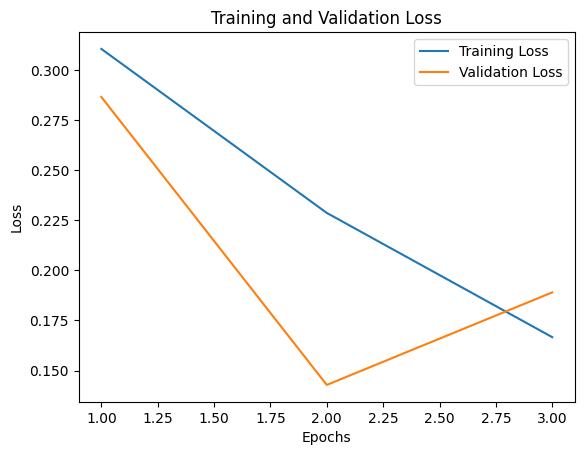

In [ ]:
# Get mean losses for each epoch
train_loss = [np.mean(x) for x in batches_losses]
val_loss = [np.mean(x) for x in val_losses]
# Plot losses
epochs = range(1, EPOCH+1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# Save the figure
plt.savefig('/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/figures/cimean Train and Val Loss.png')
# show the figure
plt.show()

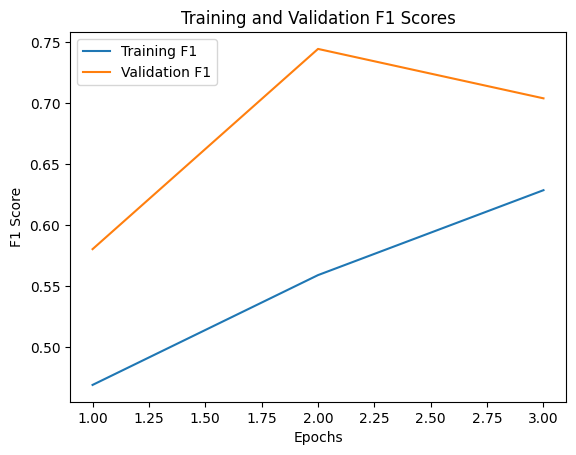

In [ ]:
# Plot F1 scores
epochs = range(1, EPOCH+1)
norm_val_f1 = [x/100 for x in val_f1]
plt.plot(epochs, train_f1, label='Training F1')
plt.plot(epochs, norm_val_f1, label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Scores')
plt.legend()
# Save the figure
plt.savefig('/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/figures/cimean Train and Val F1.png')
# show the figure
plt.show()

## Case Importance as Regression

In [7]:
task_type = "case importance"
pooling_method = "mean"

train_dataset = ECHRDataset(
    tokenizer = bert_tokenizer,
    chunk_len = CHUNK_LEN,
    file_location = "/content/drive/MyDrive/Graduation project/CSVs/final train data.csv",
    overlap_len = OVERLAP_LEN,
    task_type = task_type,
    )

valid_dataset = ECHRDataset(
    tokenizer = bert_tokenizer,
    chunk_len = CHUNK_LEN,
    file_location = "/content/drive/MyDrive/Graduation project/CSVs/test data.csv",
    overlap_len = OVERLAP_LEN,
    task_type = task_type,
    )

train_dataset_size = len(train_dataset)
valid_dataset_size = len(valid_dataset)
train_indices = list(range(train_dataset_size))
val_indices = list(range(valid_dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(train_indices)

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader = DataLoader(
    train_dataset,
    batch_size = TRAIN_BATCH_SIZE,
    sampler = train_sampler,
    collate_fn = c_utl.collate_samples)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = TRAIN_BATCH_SIZE,
    sampler = valid_sampler,
    collate_fn = c_utl.collate_samples)

device = "cuda"
lr = 3e-5
num_training_steps = int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCH)

model_hierarchical = BERT_Hierarchical_Model_Reg(pooling_method = pooling_method, task_type = task_type).to(device)
# model_hierarchical = torch.load("/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/ci-model-mean/model_epoch3_Reg2.pt")

optimizer = AdamW(model_hierarchical.parameters(), lr = lr)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses = []
batches_losses = []
train_mae = []
val_f1 = []

for epoch in range(EPOCH):
    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp, batches_mae_tmp = c_utl.hbert_lstm_training_loop_reg(train_data_loader, model_hierarchical, optimizer, device, Calculate_MAE = True)
    epoch_loss=np.mean(batches_losses_tmp)
    epoch_mae = np.mean(batches_mae_tmp)
    print(f"\n==> train : avg_loss : {epoch_loss:.2f}")
    batches_mae_tmp = np.array(batches_mae_tmp)
    train_mae.append(batches_mae_tmp.mean())
    output, target, val_losses_tmp = c_utl.hbert_lstm_evaluation_loop_reg(valid_data_loader, model_hierarchical, device)
    print(f"\n==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}\n")
    tmp_evaluate = c_utl.evaluate_reg(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_f1.append(tmp_evaluate['MAE'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    torch.save(model_hierarchical, f"/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/ci-model-mean/model_epoch{epoch+1}_Reg2.pt")
    print(f"\t§§ the Hierarchical {pooling_method} pooling model has been saved §§")

Some weights of the model checkpoint at nlpaueb/bert-base-uncased-echr were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



=============== EPOCH 1 / 6 ===============

___ batch index = 0 / 1054 (0.00%), loss = 2.5035 ___
___ batch index = 250 / 1054 (23.72%), loss = 0.6631 ___
___ batch index = 500 / 1054 (47.44%), loss = 0.7481 ___
___ batch index = 750 / 1054 (71.16%), loss = 0.9338 ___
___ batch index = 1000 / 1054 (94.88%), loss = 0.7786 ___

==> train : avg_loss : 0.84

==> evaluation : avg_loss = 0.50

=====>	{'MAE': 0.49}
	§§ the Hierarchical mean pooling model has been saved §§

=============== EPOCH 2 / 6 ===============

___ batch index = 0 / 1054 (0.00%), loss = 1.1250 ___
___ batch index = 250 / 1054 (23.72%), loss = 0.9193 ___
___ batch index = 500 / 1054 (47.44%), loss = 0.9123 ___
___ batch index = 750 / 1054 (71.16%), loss = 0.8162 ___
___ batch index = 1000 / 1054 (94.88%), loss = 0.8154 ___

==> train : avg_loss : 0.82

==> evaluation : avg_loss = 0.48

=====>	{'MAE': 0.46}
	§§ the Hierarchical mean pooling model has been saved §§

=============== EPOCH 3 / 6 ===============

___ batch 

## Hierarchical Method (Mean Pooling) (task type : multi label)


In [ ]:
task_type = "multi label"
pooling_method = "mean"

train_dataset = ECHRDataset(
    tokenizer = bert_tokenizer,
    chunk_len = CHUNK_LEN,
    file_location = "/content/drive/MyDrive/Graduation project/CSVs/less articles train data.csv",
    overlap_len = OVERLAP_LEN,
    task_type = task_type,
    )

valid_dataset = ECHRDataset(
    tokenizer = bert_tokenizer,
    chunk_len = CHUNK_LEN,
    file_location = "/content/drive/MyDrive/Graduation project/CSVs/less articles test data.csv",
    overlap_len = OVERLAP_LEN,
    task_type = task_type,
    )

train_dataset_size = len(train_dataset)
valid_dataset_size = len(valid_dataset)
train_indices = list(range(train_dataset_size))
val_indices = list(range(valid_dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(train_indices)

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader = DataLoader(
    train_dataset,
    batch_size = TRAIN_BATCH_SIZE,
    sampler = train_sampler,
    collate_fn = m_utl.collate_samples)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = TRAIN_BATCH_SIZE,
    sampler = valid_sampler,
    collate_fn = m_utl.collate_samples)


device = "cuda"
lr = 3e-5 #1e-3
num_training_steps = int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCH)

model_hierarchical = BERT_Hierarchical_Model(pooling_method = pooling_method, task_type = task_type).to(device)
optimizer = AdamW(model_hierarchical.parameters(), lr = lr)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses = []
batches_losses = []
val_acc = []
train_f1 = []
val_f1 = []

for epoch in range(EPOCH):

    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp, batches_f1_tmp = m_utl.hbert_lstm_training_loop(train_data_loader, model_hierarchical, optimizer, device, calculate_f1 = True)
    epoch_loss=np.mean(batches_losses_tmp)
    epoch_f1 = np.mean(batches_f1_tmp)
    print(f"\n==> train : avg_loss : {epoch_loss:.2f}")
    batches_f1_tmp = np.array(batches_f1_tmp)
    train_f1.append(batches_f1_tmp.mean())
    output, target, val_losses_tmp = m_utl.hbert_lstm_evaluation_loop(valid_data_loader, model_hierarchical, device)
    print(f"\n==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}\n")
    tmp_evaluate = m_utl.evaluate(target, output)
    print(f"=====>\t{tmp_evaluate}")
    val_losses.append(val_losses_tmp)
    val_f1.append(tmp_evaluate['F1-Score'])
    batches_losses.append(batches_losses_tmp)
    torch.save(model_hierarchical, f"/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/ml-model-mean/model_epoch{epoch+1}.pt")
    print(f"\t§§ the Hierarchical {pooling_method} pooling model has been saved §§")

Some weights of the model checkpoint at nlpaueb/bert-base-uncased-echr were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



=============== EPOCH 1 / 3 ===============

___ batch index = 0 / 1047 (0.00%), loss = 1.6929 ___
___ batch index = 250 / 1047 (23.88%), loss = 0.3827 ___
___ batch index = 500 / 1047 (47.76%), loss = 0.2832 ___
___ batch index = 750 / 1047 (71.63%), loss = 0.2991 ___
___ batch index = 1000 / 1047 (95.51%), loss = 0.1727 ___

==> train : avg_loss : 0.34

==> evaluation : avg_loss = 0.39

=====>	{'F1-Score': 27.77, 'Precision': 17.44, 'Recall': 68.15}
	§§ the Hierarchical mean pooling model has been saved §§

=============== EPOCH 2 / 3 ===============

___ batch index = 0 / 1047 (0.00%), loss = 0.0619 ___
___ batch index = 250 / 1047 (23.88%), loss = 0.1507 ___
___ batch index = 500 / 1047 (47.76%), loss = 0.1398 ___
___ batch index = 750 / 1047 (71.63%), loss = 0.0811 ___
___ batch index = 1000 / 1047 (95.51%), loss = 0.1248 ___

==> train : avg_loss : 0.14

==> evaluation : avg_loss = 0.37

=====>	{'F1-Score': 30.13, 'Precision': 18.64, 'Recall': 78.55}
	§§ the Hierarchical mean po

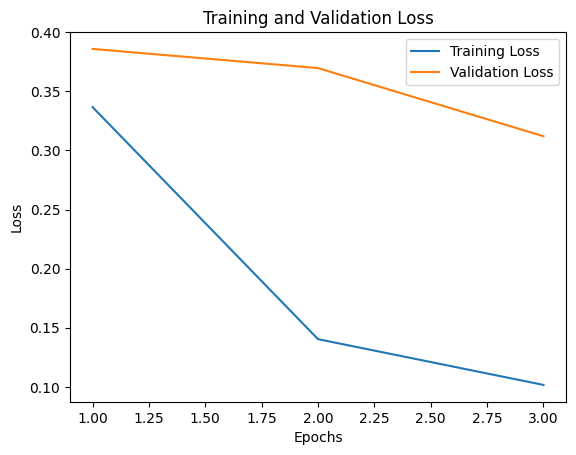

In [ ]:
# Get mean losses for each epoch
train_loss = [np.mean(x) for x in batches_losses]
val_loss = [np.mean(x) for x in val_losses]
# Plot losses
epochs = range(1, EPOCH+1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# Save the figure
plt.savefig('/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/figures/mlmean Train and Val Loss.png')
# show the figure
plt.show()

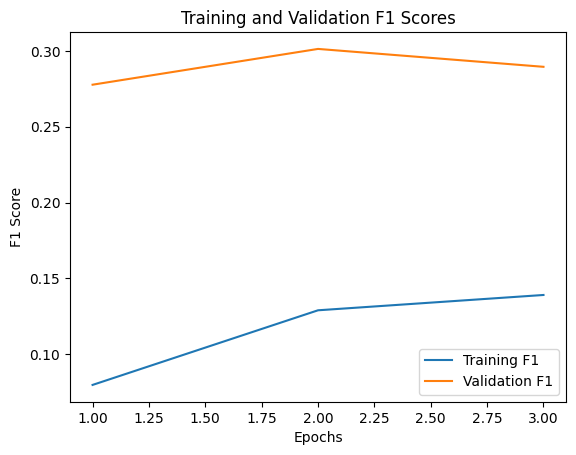

In [ ]:
# Plot F1 scores
epochs = range(1, EPOCH+1)
norm_val_f1 = [x/100 for x in val_f1]
plt.plot(epochs, train_f1, label='Training F1')
plt.plot(epochs, norm_val_f1, label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Scores')
plt.legend()
# Save the figure
plt.savefig('/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/figures/mlmean Train and Val F1.png')
# show the figure
plt.show()

## Evaluation

In [ ]:
task_type = "binary violation"
approach = "head"

valid_dataset = ECHRDataset(
    tokenizer = bert_tokenizer,
    chunk_len = CHUNK_LEN,
    file_location = "/content/drive/MyDrive/Graduation project/CSVs/test data.csv",
    overlap_len = OVERLAP_LEN,
    task_type = task_type,
    approach = approach)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = TRAIN_BATCH_SIZE,
    collate_fn = b_utl.collate_samples)

device = "cuda"

# load the state dictionary of the saved model into the new model instance
model = torch.load("/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/bv-model-head/model_epoch3.pt")

output, target, val_losses_tmp = b_utl.bert_tobert_evaluation_loop(valid_data_loader, model, device)

file_path = "/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/ensemble/head.txt"
with open(file_path, 'w') as file:
    for item in output:
        file.write(str(item) + '\n')

file.close()
print("§§ Head-Truncation list has been saved §§")

In [ ]:
output = [1 if (i >= 0.5) else 0 for i in output]
f1 = f1_score(target, output, average='macro')

In [ ]:
import ast
file_path = "/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/ensemble/head.txt"
head = []
with open(file_path, 'r') as file:
    for line in file:
        line = line.strip()
        float_value = ast.literal_eval(line)[0]
        head.append(float_value)
print(head)

[0.88876307, 0.7765835, 0.900231, 0.88841873, 0.8626533, 0.8782009, 0.90379876, 0.87550944, 0.8747491, 0.93327874, 0.901039, 0.82437974, 0.8053731, 0.9020344, 0.82940346, 0.9214522, 0.9362665, 0.7413359, 0.8678808, 0.8923245, 0.93051237, 0.8791563, 0.8855286, 0.89384896, 0.78489107, 0.75271297, 0.7702049, 0.8820254, 0.90943843, 0.8402695, 0.82331556, 0.86680764, 0.8591208, 0.8571843, 0.7451116, 0.8581271, 0.9004755, 0.9089322, 0.775458, 0.88318455, 0.91391724, 0.9291307, 0.9216615, 0.8072759, 0.90696645, 0.88371855, 0.9274864, 0.87096417, 0.8894242, 0.01155663, 0.01151512, 0.01055294, 0.01237759, 0.01036589, 0.818905, 0.8667033, 0.85672176, 0.9258135, 0.77852625, 0.8858668, 0.8847688, 0.91683346, 0.77698946, 0.92898077, 0.84696984, 0.9224681, 0.90640265, 0.9138345, 0.8728576, 0.8761294, 0.83674157, 0.8910723, 0.87788856, 0.8996358, 0.02736662, 0.01628331, 0.01923105, 0.00986558, 0.03445522, 0.012268, 0.01246165, 0.01471807, 0.01577965, 0.877879, 0.02294547, 0.91803247, 0.9096836, 0.914

## Export packages

In [ ]:
!pip freeze > '/content/drive/MyDrive/Neural_Legal_Judgment_Prediction/packages.txt'